### Global imports

In [1]:
import sys
import os
import skimage.color
from packages.video_utils import H264Extractor, VideoHandler, Gop
from packages.constants import GOP_SIZE, FRAME_HEIGHT, FRAME_WIDTH

/home/thomas/Documents/h4vdm/h4vdm-repo/.env/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
project_path = os.getcwd()
bin_path = os.path.abspath(os.path.join(project_path, 'h264-extractor', 'bin'))
h264_ext_bin = os.path.join(bin_path, 'h264dec_ext_info')

extractor = H264Extractor(h264_ext_bin, os.path.join(project_path, '.cache'))

video_filename = os.path.join(project_path, 'bunny.mp4')

h264_filename = extractor.convert_to_h264(video_filename)
yuv_filename, coded_data_filename = extractor.extract_yuv_and_codes(h264_filename)

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

------------------------------------------------------


In [3]:
video_handler = VideoHandler(video_filename, h264_filename, yuv_filename, coded_data_filename)

gop = Gop(video_handler, GOP_SIZE, FRAME_HEIGHT, FRAME_WIDTH)

print(f'GOP length: {gop.length}')
print(gop.intra_frame.shape)
for i, inter_frame in enumerate(gop.inter_frames):
    print(f'Frame {i} shape: {inter_frame.shape}')
print(f'Frame types {gop.frame_types}')
print(f'Macroblock types {gop.mb_types}')
print(f'Luma QPs {gop.luma_qps}')

GOP length: 10
(720, 1280, 3)
Frame 0 shape: (720, 1280, 3)
Frame 1 shape: (720, 1280, 3)
Frame 2 shape: (720, 1280, 3)
Frame 3 shape: (720, 1280, 3)
Frame 4 shape: (720, 1280, 3)
Frame 5 shape: (720, 1280, 3)
Frame 6 shape: (720, 1280, 3)
Frame 7 shape: (720, 1280, 3)
Frame 8 shape: (720, 1280, 3)
Frame 9 shape: (720, 1280, 3)
Frame types [0, 1, 2, 2, 2, 1, 2, 2, 2, 1]
Macroblock types [4, 4, 4, 4, 4, 4, 1, 1, 1, 4, 1, 4, 4, 4, 4, 4, 4, 4, 1, 1, 1, 1, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 1, 1, 4, 1, 4, 4, 4, 4, 4, 4, 4, 4, 1, 4, 1, 4, 4, 4, 1, 1, 4, 4, 4, 4, 1, 1, 4, 4, 1, 4, 4, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 4, 4, 4, 1, 4, 4, 4, 1, 4, 4, 4, 4, 4, 4, 1, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 4, 4, 4, 1, 1, 4, 4, 4, 1, 4, 4, 4, 1, 4, 4, 4, 4, 1, 1, 4, 1, 4, 4, 4, 4, 1, 1, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 1, 4, 1, 1, 4, 4, 1, 1, 1, 1, 1, 1, 1, 1, 4, 1, 4, 1, 1, 4, 4, 4, 4, 4, 4, 4, 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'Frame 0 decoded')

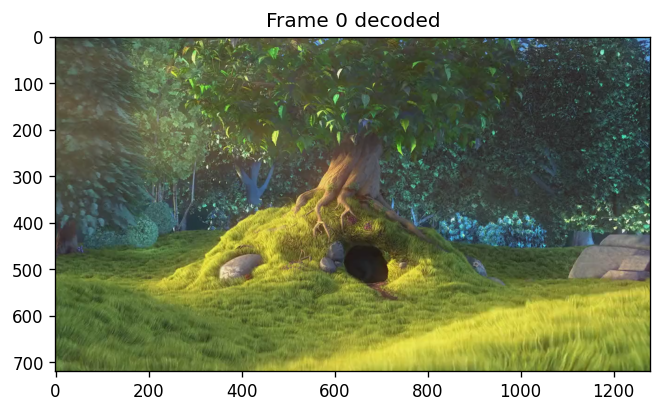

In [4]:
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 120
from matplotlib.patches import Rectangle
from matplotlib.lines import Line2D
import numpy as np

frame_id = 0
plt.imshow(gop.get_rgb_frame(frame_id))
plt.title('Frame {} decoded'.format(frame_id))

In [5]:
# now, visualize the encoding parameters

# first we need to get the size of the macroblocks from the enums

import re
from slice_pb2 import MacroblockType

# parse the size of macroblocks from the enum names
mb_size_regex = re.compile('([0-9]{1,2})x([0-9]{1,2})')
mb_size_dict = dict()
# Iterate through all the enum entries to build a dictionary of macroblock sizes
for key, val in MacroblockType.items():
    search_result = mb_size_regex.search(key)
    if search_result is not None:
        mb_size_x = int(search_result.group(1))
        mb_size_y = int(search_result.group(2))
        mb_size_dict[key] = (mb_size_x, mb_size_y)
    else:
        mb_size_dict[key] = (16, 16)

# show some entires
for key in list(mb_size_dict.keys())[:10]:
    print(f'{key}={mb_size_dict[key]}')

MB_TYPE_PLACEHOLDER=(16, 16)
MB_TYPE_INTRA4x4=(4, 4)
MB_TYPE_INTRA16x16=(16, 16)
MB_TYPE_INTRA8x8=(8, 8)
MB_TYPE_16x16=(16, 16)
MB_TYPE_16x8=(16, 8)
MB_TYPE_8x16=(8, 16)
MB_TYPE_8x8=(8, 8)
MB_TYPE_8x8_REF0=(8, 8)
MB_TYPE_SKIP=(16, 16)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


AttributeError: 'int' object has no attribute 'x'

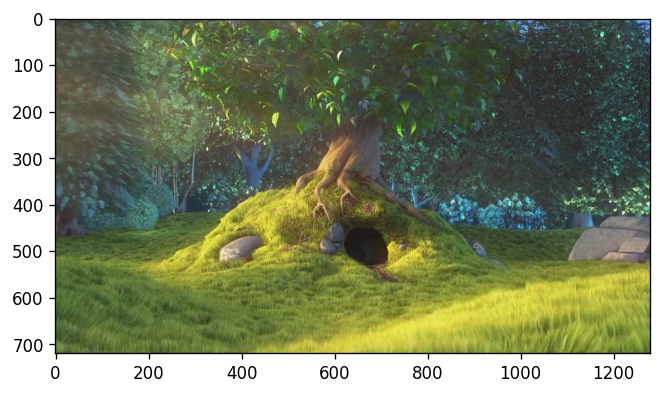

In [9]:
# now, begin the visualization
plt.imshow(gop.get_rgb_frame(frame_id))
ax = plt.gca()

mb_color_cycle = plt.get_cmap('Set1')
mb_alpha = 0.5
mb_colors = np.asarray([mb_color_cycle(i) for i in range(5)])
mb_colors[:, 3] = mb_alpha
mb_labels = ['INTRA', 'DIRECT_SKIP', 'SKIP', 'DIRECT', 'INTER']
line_color = 'black'
line_width = 0.2

for mb in slice.mbs:
    mb_type = MacroblockType.Name(mb.type)
    mb_size = mb_size_dict[mb_type]

    mb_label_index = None

    # determine the color
    if 'INTRA' in mb_type:
        mb_label_index = 0
    elif 'SKIP' in mb_type and 'DIRECT' in mb_type:
        mb_label_index = 1
    elif 'SKIP' in mb_type:
        mb_label_index = 2
    elif 'DIRECT' in mb_type:
        mb_label_index = 3
    else:
        mb_label_index = 4

    color = mb_colors[mb_label_index]
    
    # compute the lower left corner of the macroblock
    mb_x = mb.x * 16
    mb_y = mb.y * 16

    patches = []

    if mb_size == (16, 16):
        patches.append(Rectangle((mb_x, mb_y), 16, 16, 
            facecolor=color, edgecolor=line_color, linewidth=line_width))
    elif mb_size == (8, 16):
        patches.append(Rectangle((mb_x, mb_y), 8, 16, 
            facecolor=color, edgecolor=line_color, linewidth=line_width))
        patches.append(Rectangle((mb_x + 8, mb_y), 8, 16, 
            facecolor=color, edgecolor=line_color, linewidth=line_width))
    elif mb_size == (16, 8):
        patches.append(Rectangle((mb_x, mb_y), 16, 8, 
            facecolor=color, edgecolor=line_color, linewidth=line_width))
        patches.append(Rectangle((mb_x, mb_y+8), 16, 8, 
            facecolor=color, edgecolor=line_color, linewidth=line_width))
    elif mb_size == (8, 8):
        for i in range(2):
            for j in range(2):
                patches.append(Rectangle((mb_x+i*8, mb_y+j*8), 8, 8, 
                    facecolor=color, edgecolor=line_color, linewidth=line_width))
    elif mb_size == (4,4):
        for i in range(4):
            for j in range(4):
                patches.append(Rectangle((mb_x+i*4, mb_y+j*4), 4, 4, 
                    facecolor=color, edgecolor=line_color, linewidth=line_width))
    else:
        raise ValueError(f'unsupported macroblock size {mb_size}')

    for patch in patches:
        ax.add_patch(patch)

# generate the legend
custom_legends = [Line2D([0], [0], color=x, lw=3) for x in mb_colors]
plt.legend(custom_legends, mb_labels, bbox_to_anchor=(1.1, 1.05))
plt.title('Macroblock Partition and Type')